Use conda environment `conda_envs/coolpuppy.yml` to run this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import re

warnings.filterwarnings("ignore", category=FutureWarning)

# Matplotlib settings
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

colors = {'NeuN+': sns.color_palette()[4], 
          'NeuN-': sns.color_palette()[1]}

# Input data and parameters

[Link](https://console.cloud.google.com/storage/browser/_details/neuro-dev/Processed_data/RNA-all_full-counts-and-downsampled-CPM.h5ad?inv=1&invt=Ab0-Ew) to `RNA-all_full-counts-and-downsampled-CPM.h5ad` file

In [2]:
# INPUT DATA

# Count matrix from Herring et al. 2022
scrnaseq_path = "/tank/projects/schizophrenia_2021/data/herring2022/"\
                "RNA-all_full-counts-and-downsampled-CPM.h5ad"

# Annotation of PcG contact anchors in adult neurons
hand_anch_path = "/tank/projects/polycomb/data/polycomb_dot_anchors.5kb.16_06_25.csv"

# Expression counts from bulk RNA-seq of adult neurons (Rizzardi et al., 2019)
riz_cnts_path = "/tank/projects/schizophrenia_2021/results/2022.10.07/rizzardi.logTPM_counts.csv"

# Differentially expressed genes between adult NeuN+ and NeuN- cells from bulk RNA-seq (Rizzardi et al., 2019)
riz_deseq_path = "/tank/projects/schizophrenia_2021/results/2022.10.07/rizzardi.DEseq2_results.tsv"

# Version of gene annotation used in Herring et al. paper
herr_ann_path = "/tank/projects/schizophrenia_2021/results/2023.11.13/gencode.v19.annotation.tsv.gz"

# Description of genes coding for Polycomb subunits
pol_gen_path = '/tank/projects/nvaulin_hic_sch/reference/polycomb_subunits.tsv'

gencode.v19.annotation.tsv.gz file was obtained using command:

```zcat gencode.v19.annotation.gtf.gz | awk 'OFS="\t" {if ($3=="gene") {print $1,$4-1,$5,$10,$18,$7,$14}}' | tr -d '";' | sed 's/\(ENSG[0-9]*\)\.[0-9]*/\1/g' | gzip > gencode.v19.annotation.tsv.gz```

source: https://www.biostars.org/p/56280/

In [3]:
# PARAMETERS


# Work with scRNA-seq

In [13]:
adata = ad.read(scrnaseq_path)

In [14]:
# Check that .X contains counts
unique, counts = np.unique(adata[:, 'SOX2'].X.A, return_counts=True)
print(np.asarray((unique, counts)).T)

[[0.0000e+00 1.1590e+05]
 [1.0000e+00 2.4437e+04]
 [2.0000e+00 8.5920e+03]
 [3.0000e+00 3.3320e+03]
 [4.0000e+00 1.3760e+03]
 [5.0000e+00 6.0300e+02]
 [6.0000e+00 2.5500e+02]
 [7.0000e+00 1.1500e+02]
 [8.0000e+00 6.3000e+01]
 [9.0000e+00 3.5000e+01]
 [1.0000e+01 1.1000e+01]
 [1.1000e+01 1.7000e+01]
 [1.2000e+01 3.0000e+00]
 [1.3000e+01 4.0000e+00]
 [1.4000e+01 2.0000e+00]
 [1.5000e+01 1.0000e+00]
 [1.7000e+01 2.0000e+00]]


In [22]:
sc.__version__

'1.10.1'

In [15]:
adata.layers["norm_log1p"] = adata.X.copy()
sc.pp.normalize_total(adata, layer='norm_log1p')
sc.pp.log1p(adata, layer='norm_log1p')

In [16]:
# Save adata with new layer
adata.write("RNA-all_full-counts-and-downsampled-CPM.log1p_layer.h5ad")

In [3]:
adata = ad.read("RNA-all_full-counts-and-downsampled-CPM.log1p_layer.h5ad")

In [4]:
# Load annotation of anchors of PcG contacts
hand_anch = pd.read_csv(hand_anch_path)
hand_anch.head()

,chrom,start,end,genes
0,chr1,18630000,18640000,PAX7
1,chr1,24930000,24940000,RUNX3
2,chr1,44410000,44420000,RNF220
3,chr1,46480000,46490000,NaN
4,chr1,47180000,47250000,"TAL1,AL135960.1"


In [5]:
# Extract gene names
hand_genes_all = hand_anch['genes'].dropna().str.split(',').values
hand_genes_all = [item for sublist in hand_genes_all for item in sublist]

In [6]:
# Add expression counts info
riz_cnts = pd.read_table(riz_cnts_path, sep=',')
hand_all_cnts = riz_cnts.loc[riz_cnts['gene.name'].isin(hand_genes_all)]

# Add second name of EOMES - TBR2
# hand_all_cnts['gene.name'].replace("EOMES", "TBR2", inplace=True)
# hand_all_cnts.loc[hand_all_cnts['gene.name'] == 'EOMES', 'gene.id'] = 'ENSG00000163508'

# Add DE info
riz_deseq_res = pd.read_table(riz_deseq_path, usecols=['gene', 'log2FoldChange', 'padj'])\
    .rename(columns={'log2FoldChange': 'log2FC'})
hand_all_cnts = hand_all_cnts.merge(riz_deseq_res, left_on='gene.id', right_on='gene', how='inner')\
    .drop(columns='gene')

hand_all_cnts.head()

,chrom,start,end,gene.name,strand,gene.id,gene.type,log2TPM_NeuN+,log2TPM_NeuN-,log2FC,padj
0,chr2,72129237,72147862,CYP26B1,-,ENSG00000003137,protein_coding,3.003552,0.963682,2.362751,3.165574e-06
1,chr7,26667067,26995239,SKAP2,-,ENSG00000005020,protein_coding,0.702446,0.515608,0.762166,4.760070e-02
2,chr7,27181156,27185232,HOXA11,-,ENSG00000005073,protein_coding,0.000000,0.118441,-0.200278,NaN
3,chr7,97732083,97740472,TAC1,+,ENSG00000006128,protein_coding,2.964851,0.284815,3.975124,2.936561e-07
4,chr7,97005552,97011040,DLX6,+,ENSG00000006377,protein_coding,3.610105,0.593000,4.173928,1.990013e-08


In [7]:
# Overlap hand genes with genes from gene annotation used in Herring et al.
herr_ann = pd.read_table(herr_ann_path, names=['chrom', 'start', 'end', 'gene.id', 
                                               'gene.name', 'strand', 'gene.type'])
herr_ann.head()

,chrom,start,end,gene.id,gene.name,strand,gene.type
0,chr1,11868,14412,ENSG00000223972,DDX11L1,+,pseudogene
1,chr1,14362,29806,ENSG00000227232,WASH7P,-,pseudogene
2,chr1,29553,31109,ENSG00000243485,MIR1302-11,+,lincRNA
3,chr1,34553,36081,ENSG00000237613,FAM138A,-,lincRNA
4,chr1,52472,54936,ENSG00000268020,OR4G4P,+,pseudogene


In [8]:
# Find hand genes that are not present in Herring et al. gene annotation
hand_all_cnts.loc[~hand_all_cnts['gene.id'].isin(herr_ann['gene.id'])]

,chrom,start,end,gene.name,strand,gene.id,gene.type,log2TPM_NeuN+,log2TPM_NeuN-,log2FC,padj
410,chr1,63326924,63326984,MIR6068,-,ENSG00000275836,miRNA,0.000000,0.000000,0.000000,NaN
411,chr5,181043402,181043484,MIR8089,-,ENSG00000277912,miRNA,0.000000,3.889703,-0.203807,NaN
412,chr4,13526318,13534335,LINC01097,-,ENSG00000281202,lncRNA,0.000000,0.322080,-0.613692,NaN
413,chr11,31812306,32002405,PAUPAR,+,ENSG00000281880,lncRNA,0.008049,0.347589,-5.886355,1.036493e-10
414,chr6,10404501,10407928,TFAP2A-AS2,+,ENSG00000285278,lncRNA,0.000000,1.706761,-3.103677,1.622263e-02


There are no p-c genes out of these four, so all p-c genes are present in the annotation. This means that if a gene is not present in `adata`, then it was filtered due to low number of counts

# Align scRNA-seq data from Herring et al. with snm3c-seq data from Heffel et al.

## Get expression counts

In [9]:
heff_age = ['ga22', 'ga24', 'ga34', '118d', '179d', '20yr', '25yr']
adata_neu = adata[(adata.obs['cell_type'].isin(['PN', 'IN'])) & 
                  (adata.obs['age'].isin(heff_age))]

# Find highly variable genes
sc.pp.highly_variable_genes(adata_neu, layer='norm_log1p')

/home/ipletenev/.conda/envs/coolpup/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:664: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [31]:
# Get mean gene expression by Heffel stages
age2stage = {
    "ga22": '2T', "ga24": '2T',
    'ga34': '3T',
    "118d": 'infant', '179d': 'infant',
    '20yr': 'adult', '25yr': 'adult'
}
adata_neu.obs['heff_stage'] = adata_neu.obs['age'].map(age2stage)
heff_expr = sc.get.aggregate(adata_neu, 'heff_stage', "sum")
sc.pp.normalize_total(heff_expr, target_sum=1e6, layer='sum')
sc.pp.log1p(heff_expr, layer='sum')
heff_expr = heff_expr.to_df(layer='sum').T
name2id = dict(zip(adata_neu.var_names, adata_neu.var['gene_ids'])) # add gene ids
name2hv = dict(zip(adata_neu.var_names, adata_neu.var['highly_variable'])) # add highly_variable info
heff_expr['gene.id'] = heff_expr.index.map(name2id)
heff_expr['highly_variable'] = heff_expr.index.map(name2hv)

# Replace incorrect ENS id for PCGF2
heff_expr.loc['PCGF2', 'gene.id'] = 'ENSG00000277258'
heff_expr.loc['C17orf96', 'gene.id'] = 'ENSG00000273604'

# heff_expr.to_csv("Herring_expr_for_Heffel_stages.log1p_CPM.csv")

heff_expr.head()

,2T,3T,adult,infant,gene.id,highly_variable
RP11-34P13.7,0.450574,0.578892,0.991218,0.514575,ENSG00000238009,False
AL627309.1,0.159391,0.186096,0.477664,0.123685,ENSG00000237683,False
RP11-34P13.14,0.059200,0.033521,0.014139,0.042951,ENSG00000239906,False
AP006222.2,2.695544,1.880473,3.054285,2.979656,ENSG00000228463,False
RP4-669L17.10,2.131827,3.526323,3.029814,2.591273,ENSG00000237094,False


In [13]:
# Get mean expression by Heffel stages separately for EN and IN
def get_mean_expr(adata, ct):
    age2stage = {
        "ga22": '2T', "ga24": '2T',
        'ga34': '3T',
        "118d": 'infant', '179d': 'infant',
        '20yr': 'adult', '25yr': 'adult'
    }
    adata_cur = adata[adata.obs['cell_type'] == ct]
    adata_cur.obs['heff_stage'] = adata_cur.obs['age'].map(age2stage)
    # heff_expr = sc.get.aggregate(adata_cur, 'heff_stage', "mean", layer='norm_log1p')\
    #     .to_df(layer='mean').T
    heff_expr = sc.get.aggregate(adata_cur, 'heff_stage', "sum")
    sc.pp.normalize_total(heff_expr, target_sum=1e6, layer='sum')
    sc.pp.log1p(heff_expr, layer='sum')
    heff_expr = heff_expr.to_df(layer='sum').T
    name2id = dict(zip(adata_cur.var_names, adata_cur.var['gene_ids'])) # add gene ids
    name2hv = dict(zip(adata_cur.var_names, adata_cur.var['highly_variable'])) # add highly_variable info
    heff_expr['gene.id'] = heff_expr.index.map(name2id)
    heff_expr['highly_variable'] = heff_expr.index.map(name2hv)
    
    # Replace incorrect ENS id for PCGF2
    heff_expr.loc['PCGF2', 'gene.id'] = 'ENSG00000277258'
    heff_expr.loc['C17orf96', 'gene.id'] = 'ENSG00000273604'

    return heff_expr


heff_expr_ct = {}
for ct in ['PN', 'IN']:
    heff_expr_ct[ct] = get_mean_expr(adata_neu, ct)#.drop(columns='highly_variable')
    # heff_expr_ct[ct].to_csv(f"Herring_expr_for_Heffel_stages.{ct}.log1p_CPM.csv")

/tmp/ipykernel_3747924/2482110199.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cur.obs['heff_stage'] = adata_cur.obs['age'].map(age2stage)
/tmp/ipykernel_3747924/2482110199.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cur.obs['heff_stage'] = adata_cur.obs['age'].map(age2stage)


In [14]:
heff_expr_ct = {
    ct: pd.read_table(f"Herring_expr_for_Heffel_stages.{ct}.csv", sep=',', index_col=0)
    for ct in ['PN', 'IN']
}

FileNotFoundError: [Errno 2] No such file or directory: 'Herring_expr_for_Heffel_stages.PN.csv'

## Get non-expressed genes

In [15]:
adata_hand = adata_neu[:, adata_neu.var['gene_ids'].isin(hand_all_cnts['gene.id'])]
adata_hand.var['max_count'] = np.max(adata_hand.X.A, axis=0)
adata_hand.var['total_counts'] = np.sum(adata_hand.X.A, axis=0)
adata_hand.var['gene_name'] = adata_hand.var.index
adata_hand.var['total_count_grp'] = adata_hand.var['total_counts']\
    .apply(lambda tc: 
           "0" if tc <= 100  
           else "1" if tc <= 1_000 
           else "2" if tc <= 10_000 
           else "3" if tc <= 100_000 
           else "4")
# adata_hand = adata_hand[:, adata_hand.var['total_counts'] > 100]
adata_hand.shape

/tmp/ipykernel_3747924/3185908151.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_hand.var['max_count'] = np.max(adata_hand.X.A, axis=0)


(36826, 251)

In [16]:
# Get polycombed genes with less than 100 counts
max_cnt = 100
ex_hv_gene = adata_hand[:, (adata_hand.var['total_counts'] > max_cnt) | 
                           (adata_hand.var['highly_variable'] == True)].var['gene_ids'].values
noex_gene = hand_all_cnts.loc[~hand_all_cnts['gene.id'].isin(ex_hv_gene)]

# Additionally remove genes with log2TPM in NeuN+ > 1 (Rizzardi et al. data)
noex_gene = noex_gene.loc[noex_gene['log2TPM_NeuN+'] < 1]
print(noex_gene.shape)
noex_gene.head()

(237, 11)


,chrom,start,end,gene.name,strand,gene.id,gene.type,log2TPM_NeuN+,log2TPM_NeuN-,log2FC,padj
2,chr7,27181156,27185232,HOXA11,-,ENSG00000005073,protein_coding,0.000000,0.118441,-0.200278,NaN
6,chr6,50818722,50847619,TFAP2B,+,ENSG00000008196,protein_coding,0.000000,0.232656,-2.404967,4.549555e-02
9,chr5,51383447,51394730,ISL1,+,ENSG00000016082,protein_coding,0.110716,0.022126,0.072973,NaN
10,chr1,24899510,24965121,RUNX3,-,ENSG00000020633,protein_coding,0.000000,0.340015,-6.270506,4.871913e-07
12,chr12,54008984,54012769,HOXC8,+,ENSG00000037965,protein_coding,0.175934,0.352102,-0.664244,NaN


In [20]:
noex_gene.loc[noex_gene['gene.name'].isin(['GPX8', 'CDC20B'])]

,chrom,start,end,gene.name,strand,gene.id,gene.type,log2TPM_NeuN+,log2TPM_NeuN-,log2FC,padj
197,chr5,55160166,55167297,GPX8,+,ENSG00000164294,protein_coding,0.0,0.05197,-0.186574,NaN


In [17]:
# Get anchors with non-expressed genes (both p-c and non-c)
def noex_genes(gene_l, noex_l):
    ex_l = [gene for gene in gene_l if gene not in noex_l]
    if len(ex_l) == 0:
        return True
    else:
        return False

# Keep genes that are present in rizzardi
hand_anch_flt = hand_anch.copy().fillna('no_gene')
hand_anch_flt['genes_riz'] = hand_anch_flt['genes'].str.split(',')\
    .apply(lambda genes: [gene for gene in genes if gene in hand_all_cnts['gene.name'].values])

# Mark non-expressed genes based on Herring and Rizzardi
hand_anch_flt['noex'] = hand_anch_flt['genes_riz'].apply(noex_genes, args=[noex_gene['gene.name'].values])
hand_anch_flt

,chrom,start,end,genes,genes_riz,noex
0,chr1,18630000,18640000,PAX7,[PAX7],False
1,chr1,24930000,24940000,RUNX3,[RUNX3],True
2,chr1,44410000,44420000,RNF220,[RNF220],False
3,chr1,46480000,46490000,no_gene,[],True
4,chr1,47180000,47250000,"TAL1,AL135960.1",[TAL1],True
...,...,...,...,...,...,...
257,chr2,181680000,181690000,"CERKL,NEUROD1","[CERKL, NEUROD1]",False
258,chr2,218990000,219000000,CRYBA2,[CRYBA2],True
259,chr4,80260000,80270000,FGF5,[FGF5],False
260,chr10,92680000,92690000,HHEX,[HHEX],True


In [39]:
!pwd

/tank/projects/schizophrenia_2021/results/2023.11.13


In [17]:
# Save results
# hand_anch_flt.drop(columns='genes_riz').to_csv("polycomb_dot_anchors.with_noex.csv", index=False)

## Plot: distribution of total counts by groups

In [21]:
hand_pc_hef_grps = hand_all_cnts\
    .loc[hand_all_cnts['gene.type'] == 'protein_coding']\
    .merge(adata_hand.var[['gene_ids', 'total_count_grp']], 
           left_on='gene.id', right_on='gene_ids', how='left')
hand_pc_hef_grps['total_count_grp'].fillna('0', inplace=True)
hand_pc_hef_grps['total_count_grp'].value_counts()

total_count_grp
0    168
1     66
2     52
3     15
4      3
Name: count, dtype: int64

[168  66  52  15   3] 0.5526315789473685


([<matplotlib.axis.YTick at 0x7f54e0fd8e20>], [Text(0, 0, '')])

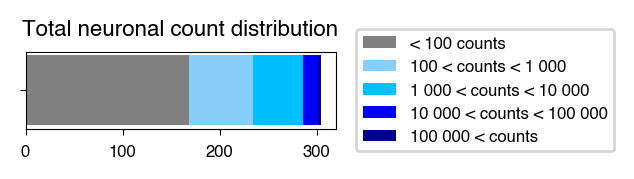

In [22]:
bars = hand_pc_hef_grps['total_count_grp'].value_counts().values
labs = ['< 100 counts', '100 < counts < 1 000', '1 000 < counts < 10 000', 
       '10 000 < counts < 100 000', '100 000 < counts']
cols = ['grey', 'lightskyblue', 'deepskyblue', 'blue', 'darkblue']
left=0

print(bars, bars[0]/sum(bars))

plt.figure(figsize=[2, 0.5], dpi=200)
for bar, col, lab in zip(bars, cols, labs):
    plt.barh(0, bar, left=left, color=col, label=lab)
    left+=bar

plt.title('Total neuronal count distribution')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=6)
plt.yticks([0], [''])
# plt.tight_layout()
# plt.savefig("total_neuronal_count_distr.pdf", bbox_inches='tight')

## Split into pseudobulk EN and IN samples

In [21]:
cts = ['PN', 'IN']
heff_age = ['ga22', 'ga24', 'ga34', '118d', '179d', '20yr', '25yr']

pb_arr = np.empty([adata_neu.shape[1], len(heff_age) * len(cts)], dtype=int)
cols = []

j = 0
for age in heff_age:
    for ct in cts:
        pb_arr[:, j] = np.squeeze(
            adata_neu[(adata_neu.obs['cell_type'] == ct) & 
                      (adata_neu.obs['age'] == age), :].X.sum(axis=0)
        )
        cols.append(age + '_' + ct)
        j += 1

pb_df = pd.DataFrame(data=pb_arr, index=adata_neu.var_names, columns=cols)
pb_df.head()

,ga22_PN,ga22_IN,ga24_PN,ga24_IN,ga34_PN,ga34_IN,118d_PN,118d_IN,179d_PN,179d_IN,20yr_PN,20yr_IN,25yr_PN,25yr_IN
RP11-34P13.7,32,1,22,1,21,2,28,14,3,1,45,9,47,18
AL627309.1,7,0,10,0,6,0,6,1,2,0,25,4,11,3
RP11-34P13.14,5,0,1,0,0,1,1,2,0,0,0,0,1,0
AP006222.2,648,59,618,34,138,25,680,317,178,102,448,191,479,301
RP4-669L17.10,312,41,349,29,837,131,412,129,236,67,616,283,325,159


In [21]:
# pb_df.to_csv("herring_pseudobulk.csv.gz", sep=',', index=True, header=True)

## Look at polycomb genes

### Plot: expression of polycomb genes at Heffel stages

In [14]:
pol_genes = pd.read_table(pol_gen_path).set_index('Name', drop=False)
print(pol_genes.shape)
pol_genes.head()

(54, 8)


,Name,Ensembl_ID,UniprotKB,Other_names,Function,Domain,Complex,Type
Name,,,,,,,,
RING1A,RING1A,ENSG00000204227,Q06587,RNF1,Ubiquitinates H2AK119,RING finger,PRC1,Core
RING1B,RING1B,ENSG00000121481,Q99496,RNF2,Ubiquitinates H2AK119,RING finger,PRC1,Core
CBX2,CBX2,ENSG00000173894,Q14781,NaN,"Bind H3K27me3, H3K9me3",Chromodomain; AT hook,PRC1,cPRC1
CBX4,CBX4,ENSG00000141582,O00257,NaN,"Bind H3K27me3, H3K9me4",Chromodomain,PRC1,cPRC1
CBX6,CBX6,ENSG00000183741,O95503,NaN,"Bind H3K27me3, H3K9me5",Chromodomain,PRC1,cPRC1


In [31]:
def reorderLegend(ax=None,order=None,unique=False):
    # Function copied from https://stackoverflow.com/questions/22263807/how-is-order-of-items-in-matplotlib-legend-determined
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels, bbox_to_anchor=(1, 1.05), fontsize=6)
    return(handles, labels)


def plot_pol_sub_fr(expr_df, pol_genes):
    stages = ['2T', '3T', 'infant', 'adult']
    pol_types = ['Core', 'cPRC1', 'ncPRC1', 'PRC2.1', 'PRC2.2', 'Auxillary']
    colors = {'2T': "#512568", "3T": '#3D6B93', 'infant': '#98CA43', 'adult': '#F9E51B'}
    
    heff_expr_pol = pol_genes.merge(expr_df, how='inner', left_on='Ensembl_ID', right_on='gene.id').set_index('Name')
    heff_expr_pol[stages] = heff_expr_pol[stages].div(heff_expr_pol[stages].sum(axis=1), axis=0) # scale to 1
    heff_expr_pol['fetal_sum'] = heff_expr_pol[['2T', '3T']].sum(axis=1) # calculate sum to sort later
    
    n_per_type = heff_expr_pol['Type'].value_counts().loc[pol_types].values # for width ratios
    ncols = len(n_per_type)
    fig, axs = plt.subplots(1, ncols, width_ratios=n_per_type, figsize=[7, 1.25], 
                            dpi=180)
    
    for i, type in enumerate(pol_types):
        ax = axs[i]
        plot_df = heff_expr_pol.loc[heff_expr_pol['Type'] == type]\
            .sort_values(by='fetal_sum', ascending=False)
        plot_df[stages].plot(kind='bar', stacked=True, width=0.8, color=colors, ax=ax)
        # print(plot_df[stages])
        ax.scatter(np.arange(n_per_type[i]), plot_df['fetal_sum'], color='white', 
                   s=60, marker='_')
        # ax.grid(axis='y')
        ax.set_title(type, fontsize=6)
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), style='italic', ha='right', 
                           rotation=55, rotation_mode='anchor')
    
        # Legend
        if i < ncols - 1:
            ax.get_legend().remove()
        else:
            reorderLegend(ax, stages[::-1])
            # ax.legend(bbox_to_anchor=(1, 1.05), fontsize=6)
    
        # yticks
        if i > 0:
            ax.set_yticks([], minor=False)
        else:
            ax.set_ylabel('Gene expression scaled to 1', fontsize=6)
    
        # spines
        if i == 0:
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['left'].set_bounds(0, 1)
        elif i < ncols - 1:
            ax.spines[['left', 'right']].set_visible(False)
            ax.spines['bottom'].set_bounds(-1, n_per_type[i])
        else:
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # ax.spines['right'].set_bounds(0, 1)
        # ax.spines['top'].set_bounds(-0.4, n_per_type[i]-0.6)
        ax.spines['top'].set_bounds(0, n_per_type[i]-1)
            
    plt.subplots_adjust(wspace=0.035)
    return

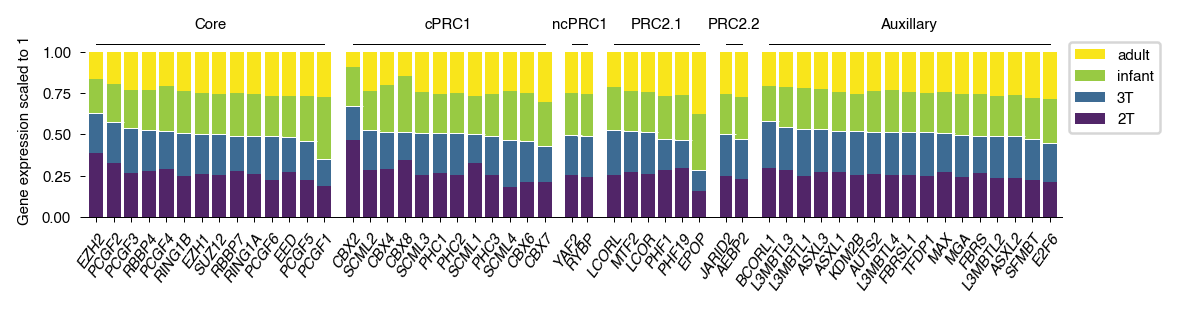

In [32]:
plot_pol_sub_fr(heff_expr, pol_genes)

### Plot: expression of polycomb paralogs

In [11]:
parals = {
    'RING1': ["RING1A", 'RING1B'],
    'EZH': ['EZH1', 'EZH2'],
    "CBX": ['CBX2', 'CBX4', 'CBX6', 'CBX7', 'CBX8'],
    'PHF1/MTF2/PHF19': ['PHF1', 'MTF2', 'PHF19'],
    "PCGF": ['PCGF1', 'PCGF2', 'PCGF3', 'PCGF4', 'PCGF5', 'PCGF6'],
    'PHC': ['PHC1', 'PHC2', 'PHC3'],
    'SCML': ['SCML1', 'SCML2', 'SCML3', 'SCML4'],
    'RYBP/YAF2': ['RYBP', 'YAF2'],
    'vPRC1.3/5': ['FBRS', 'FBRSL1', 'AUTS2']
}

In [12]:
from matplotlib.colors import LinearSegmentedColormap, Colormap


def plot_paral_prop(expr, pol_genes):
    stages = ['2T', '3T', 'infant', 'adult']
    heff_expr_pol = pol_genes.merge(expr, how='inner', left_on='Ensembl_ID', right_on='gene.id')\
        .set_index('Name')
    
    # paral = parals['RING1']
    
    paral_df = heff_expr_pol.loc[:, stages].T
    
    for p_name, p_genes in parals.items():
        paral_df[p_genes] = paral_df[p_genes].div(paral_df[p_genes].sum(axis=1), axis=0) # scale to 1
    
    ncols = len(parals)
    fig, axs = plt.subplots(1, ncols, figsize=[6, 2.5], 
                            dpi=180)
    
    for i, (p_name, p_genes) in enumerate(parals.items()):
        ax = axs[i]
        cmap = mpl.colormaps['viridis']
        # cmap = cmap_discretize('terrain', len(p_genes))
        colors = cmap(np.linspace(0, 1, len(p_genes)))
        # cmap = cmap_discretize('viridis', 6)
        # colors = cmap(np.linspace(0, 0.9, 6))[:len(p_genes)]
        paral_df[p_genes].plot(
            kind='bar', 
            stacked=True, 
            width=0.8, 
            color=colors, 
            ax=ax
        )
        # ax.set_title(p_name)
        # legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc='lower center', 
                  bbox_to_anchor=(0.5, 1.05), fontsize=6, 
                  handlelength=0.7,
                  prop={'style': 'italic', 'size': 6})
    
        # yticks
        if i > 0:
            ax.set_yticks([], minor=False)
        else:
            ax.set_ylabel('Gene expression scaled to 1', fontsize=6)

        # spines
        if i == 0:
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            # ax.spines['left'].set_bounds(0, 1)
        elif i < ncols - 1:
            ax.spines[['left', 'right']].set_visible(False)
            # ax.spines['bottom'].set_bounds(-1, 4)
        else:
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            # ax.spines['right'].set_bounds(0, 1)
        # ax.spines['top'].set_bounds(-0.4, n_per_type[i]-0.6)
        # ax.spines['top'].set_bounds(0, 3)
        ax.spines['top'].set_visible(False)
    
    plt.subplots_adjust(wspace=0)
    return

In [18]:
stages = ['2T', '3T', 'infant', 'adult']
heff_expr_pol = pol_genes.merge(heff_expr, how='inner', left_on='Ensembl_ID', right_on='gene.id')\
    .set_index('Name')

# paral = parals['RING1']

paral_df = heff_expr_pol.loc[:, stages].T

for p_name, p_genes in parals.items():
    paral_df[p_genes] = paral_df[p_genes].div(paral_df[p_genes].sum(axis=1), axis=0) # scale to 1

Name,RING1A,RING1B,CBX2,CBX4,CBX6,CBX7,CBX8,PCGF1,PCGF2,PCGF3,...,RBBP7,RBBP4,PHF1,MTF2,PHF19,EPOP,LCOR,LCORL,JARID2,AEBP2
2T,0.493444,0.506556,0.112764,0.269928,0.292943,0.207637,0.116729,0.027791,0.209149,0.231222,...,3.476532,4.868065,0.342747,0.504220,0.153033,0.778904,5.571614,5.477577,5.005074,5.210850
3T,0.457747,0.542253,0.057676,0.236926,0.393858,0.246527,0.065014,0.025598,0.165372,0.249397,...,2.657518,4.333383,0.288331,0.598574,0.113095,0.634633,5.355207,5.784730,5.120945,5.362746
infant,0.483592,0.516408,0.051731,0.239613,0.368525,0.235753,0.104378,0.056541,0.148748,0.208147,...,3.210300,4.222946,0.352129,0.490774,0.157097,1.665110,5.254490,5.601056,4.841406,5.718303
adult,0.503501,0.496499,0.025082,0.204256,0.385645,0.330332,0.054684,0.044536,0.136231,0.216498,...,3.110427,4.064873,0.361181,0.489318,0.149501,1.853572,5.152635,4.607526,5.213506,6.178624


In [19]:
# paral_df.to_csv("paralogs_expr_scaled.csv")

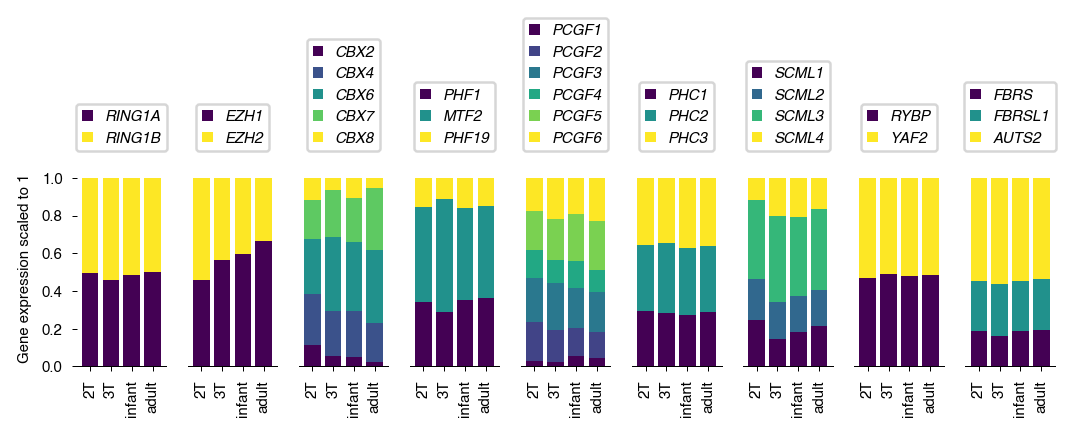

In [15]:
plot_paral_prop(heff_expr, pol_genes)
plt.tight_layout()
# plt.savefig("polycomb_paralogs.pdf")

### Calculate significance of proportions

In [39]:
# Replace to older ENS ids used in adata
pol_genes['herring_Ensembl_ID'] = pol_genes['Ensembl_ID']
pol_genes.loc['PCGF2', 'herring_Ensembl_ID'] = 'ENSG00000056661'
pol_genes.loc['C17orf96', 'herring_Ensembl_ID'] = 'ENSG00000179294'

In [40]:
adata_neu_pol = adata_neu[:, adata_neu.var['gene_ids'].isin(pol_genes['herring_Ensembl_ID'])]
adata_neu_pol.X = adata_neu_pol.layers['norm_log1p'].copy()
# adata_neu_pol.var['non-unique_names']\
#     .replace({'RNF2': 'RING1B', 'RING1': 'RING1A'}, inplace=True)
adata_neu_pol.var_names = adata_neu_pol.var['gene_ids']

In [41]:
gen2id = dict(zip(pol_genes['Name'], pol_genes['herring_Ensembl_ID']))

for grp in parals.values():
    for gene in grp:
        gene_id = gen2id[gene]
        grp_ids = [gen2id[gene] for gene in grp]
        adata_neu_pol.obs[f'{gene}_fr'] = \
            adata_neu_pol[:, gene_id].X / adata_neu_pol[:, grp_ids].X.sum(axis=1)

adata_neu_pol.obs.head()
# adata_neu_pol.obs
# print(adata_neu_pol.obs['RING1B_fr'].isna().sum())
# print(np.nanmedian(adata_neu_pol.obs['RING1B_fr']))
# print(np.nanmean(adata_neu_pol.obs['RING1B_fr']))
# plt.hist(adata_neu_pol.obs['RING1B_fr'])

/home/ipletenev/.conda/envs/coolpup/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/home/ipletenev/.conda/envs/coolpup/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/home/ipletenev/.conda/envs/coolpup/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/home/ipletenev/.conda/envs/coolpup/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/home/ipletenev/.conda/envs/coolpup/lib/python3.10/site-packages/scipy/sparse/_base.py:665: RuntimeWarning: invalid value encountered in divide
  return np.true_divide(self.todense(), other)
/home/ipletenev/.conda/envs/coolpup/lib/pytho

,batch,RL#,age,chem,concat_id,numerical_age,stage_id,Sex,Race,PMI,...,PHC3_fr,SCML1_fr,SCML2_fr,SCML3_fr,SCML4_fr,RYBP_fr,YAF2_fr,FBRS_fr,FBRSL1_fr,AUTS2_fr
AAACCCAAGAGTCTTC-RL2103_ga22_v3,RL2103_ga22_v3,RL2103,ga22,v3,7,-0.345205,Fetal,M,AA,5,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0
AAACCCAAGCTTCGTA-RL2103_ga22_v3,RL2103_ga22_v3,RL2103,ga22,v3,7,-0.345205,Fetal,M,AA,5,...,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
AAACCCACAAAGGATT-RL2103_ga22_v3,RL2103_ga22_v3,RL2103,ga22,v3,7,-0.345205,Fetal,M,AA,5,...,NaN,0.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0,1.0
AAACCCACAGTGACCC-RL2103_ga22_v3,RL2103_ga22_v3,RL2103,ga22,v3,7,-0.345205,Fetal,M,AA,5,...,0.5,0.5,0.0,0.5,0.0,NaN,NaN,0.0,0.0,1.0
AAACCCACATCCAACA-RL2103_ga22_v3,RL2103_ga22_v3,RL2103,ga22,v3,7,-0.345205,Fetal,M,AA,5,...,0.5,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,1.0


In [42]:
adata_neu_pol.obs.groupby('heff_stage')['RING1B_fr'].apply(list)\
    .apply(lambda x: [i for i in x if i == i]).apply(len) # remove nan

heff_stage
2T        5081
3T        1460
adult     2272
infant    2602
Name: RING1B_fr, dtype: int64

In [43]:
from scipy.stats import f_oneway, kruskal
rng = np.random.default_rng()


for grp in parals.values():
    for gene in grp:
        df = adata_neu_pol.obs.groupby('heff_stage')[f'{gene}_fr'].apply(list)\
            .apply(lambda x: [i for i in x if i == i]).tolist() # remove nan

        rsamps = [rng.choice(samp, 4500) for samp in df]
        # rsamps = [df.loc[idx, f'{gene}_fr'].dropna().values for idx in rsamp_idx]

        # select random sample

        # f_oneway(*df.tolist())
        # print(gene, kruskal(*df).pvalue)
        print(gene, kruskal(*rsamps).pvalue)

RING1A 2.1635029042856976e-92
RING1B 6.396643459965647e-87
EZH1 0.0
EZH2 0.0
CBX2 4.800869007164351e-57
CBX4 5.852153348695904e-191
CBX6 5.600704986796328e-214
CBX7 0.0
CBX8 6.560944775420535e-26
PHF1 1.5290155516807348e-228
MTF2 4.460677254550134e-259
PHF19 8.398540144250124e-35
PCGF1 6.5625546323454e-17
PCGF2 1.4861554596929475e-237
PCGF3 2.2242280058796332e-110
PCGF4 9.052358752056854e-27
PCGF5 0.0
PCGF6 4.413058153376055e-179
PHC1 1.2090550181853601e-70
PHC2 6.516396028330751e-31
PHC3 8.552886133229081e-52
SCML1 1.4851180681295842e-143
SCML2 2.257610937111582e-40
SCML3 4.2403800826980334e-92
SCML4 1.4679003726262542e-45
RYBP 5.742155096733678e-19
YAF2 5.177467798219843e-38
FBRS 5.9236428656827165e-102
FBRSL1 1.3191883982975337e-92
AUTS2 6.782611256066115e-114


In [44]:
## Control: calculate significance for 4 random samples from the same stage
rng = np.random.default_rng()

df = adata_neu_pol.obs.query("heff_stage == '3T'")
rsamp_idx = [rng.choice(df.index, df.shape[0] // 4) for i in range(4)]

for grp in parals.values():
    for gene in grp:
        rsamps = [df.loc[idx, f'{gene}_fr'].dropna().values for idx in rsamp_idx]
        # df = adata_neu_pol.obs.groupby('heff_stage')[f'{gene}_fr'].apply(list)\
        #     .apply(lambda x: [i for i in x if i == i]) # remove nan

        print(gene, kruskal(*rsamps).pvalue)

RING1A 0.30052134461038954
RING1B 0.30052134461038954
EZH1 0.3583321041041609
EZH2 0.3583321041041609
CBX2 0.40686168955403046
CBX4 0.2719491152937643
CBX6 0.6289925312366946
CBX7 0.29763717276531976
CBX8 0.8640421312766099
PHF1 0.8601743721237691
MTF2 0.9474965892348384
PHF19 0.5325506338724999
PCGF1 0.6163237113856457
PCGF2 0.8549251930496978
PCGF3 0.536393649337739
PCGF4 0.34964496488487967
PCGF5 0.029098534317150794
PCGF6 0.5022672133378208
PHC1 0.9484278109841975
PHC2 0.5315950263633464
PHC3 0.5168233531041848
SCML1 0.35901031905408426
SCML2 0.9167793554418366
SCML3 0.7706916213299716
SCML4 0.6427467392808286
RYBP 0.6668819328696157
YAF2 0.6668819328696157
FBRS 0.22154810818325452
FBRSL1 0.16491803019148044
AUTS2 0.03182572366685256
